# Basic tutorial: image data
#### Author: Matteo Caorsi

This short tutorial shows you how to use the basic functioning of *giotto-deep* API for an imagee classfication task.

Image classifcation is about associating a picture with a label: for example, you would like your model to be able to associate a label `cat` to the image of a cat and a label `dog` to an image of a dog:

![img](./images/image_class.png)

It is important to clarify that the set of labels has to be pre-defined and the models have to be trained with a sufficient amount of data per label.

The main steps of the tutorial are the following:
 1. Creation of a dataset
 2. Creation of a model
 3. Define metrics and losses
 4. Train your model
 5. Evaluate your model performances
 6. Use interpretability tools like heatmaps on the trained model

In [55]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import SGD
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.models as models
from gtda.diagrams import BettiCurve
from gtda.plotting import plot_betti_surfaces

from gdeep.data.datasets import DatasetBuilder, DataLoaderBuilder
from gdeep.models import FFNet
from gdeep.visualization import persistence_diagrams_of_activations
from gdeep.data.preprocessors import ToTensorImage
from gdeep.trainer import Trainer
from gdeep.models import ModelExtractor
from gdeep.analysis.interpretability import Interpreter
from gdeep.visualization import Visualiser
from gdeep.search import GiottoSummaryWriter

# Initialize the tensorboard writer

In order to analyse the results of your models, you need to start tensorboard.
On the terminal, move inside the `/examples` folder. There run the following command:

```
tensorboard --logdir=runs
```

Then go [here](http://localhost:6006/) after the training of your model to see all the visualization results.

In [56]:
writer = GiottoSummaryWriter()


# Create your dataset

In this example we will be using the `CIFAR10` dataset, which is a dataset of many thousands of images with ten classes.

In giotto-deep it is enough to call `DatasetBuilder(name="CIFAR10")` to get the dataset!

In [57]:
db = DatasetBuilder(name="CIFAR10")
ds_tr, ds_val, ds_ts = db.build()
NUMBER_OF_CLASSES = 10


## Preprocessing

The preprocessing steps consist in transforming the images to tensors. We have already provided a simple class to do such preprocessing: `ToTensorImage`.

The transformation is computed on the fly, hence is very light on the memory.

In [58]:
# Preprocessing


transformation = ToTensorImage((32, 32))
transformation.fit_to_dataset(
    ds_tr
)  # this is useless for this transformation, but in general this is the API

transformed_ds_tr = transformation.attach_transform_to_dataset(ds_tr)
transformed_ds_val = transformation.attach_transform_to_dataset(ds_val)
transformed_ds_ts = transformation.attach_transform_to_dataset(ds_ts)

# use only 320 images from cifar10 for training
train_indices = list(range(32 * 10))
val_indices = list(range(32 * 5))
test_indices = list(range(32 * 5))
dl_tr, dl_val, dl_ts = DataLoaderBuilder(
    (transformed_ds_tr, transformed_ds_val, transformed_ds_ts)
).build(
    (
        {"batch_size": 32, "sampler": SubsetRandomSampler(train_indices)},
        {"batch_size": 32, "sampler": SubsetRandomSampler(val_indices)},
        {"batch_size": 32, "sampler": SubsetRandomSampler(test_indices)},
    )
)


## Define and train your model

In the next cell we show how simple it is to build a model from `torch`, and use it for training in Giotto-deep.

In [59]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = Net()

print(model)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


## Training the model

We have prepared the dataset, we have prepared the model... it is now time to train it!

In giotto-deep it is just a matter of initialising the `Trainer` and run it with `train`. All the outputs, the exceptions, cross validation... everything is just a parameter for the trainer. Have a look at the next cell!

In [72]:

# define the loss function
loss_fn = nn.CrossEntropyLoss()

# initilise the trainer class
pipe = Trainer(model, (dl_tr,), loss_fn, writer)

# train the model
pipe.train(
    SGD,
    3,
    False,
    {"lr": 0.01},
    {"batch_size": 32, "sampler": SubsetRandomSampler(train_indices)},
    pipeline_train=True,
    nb_chunks=2,
    profiling=True
)


No TPUs...
No TPUs...
No TPUs...
LayerList 14 -> [7, 7]
Current layer 0, GPU 0, Next separation 6
Current layer 1, GPU 0, Next separation 6
Current layer 2, GPU 0, Next separation 6
Current layer 3, GPU 0, Next separation 6
Current layer 4, GPU 0, Next separation 6
Current layer 5, GPU 0, Next separation 6
Current layer 6, GPU 0, Next separation 6
Current layer 7, GPU 1, Next separation 13
Current layer 8, GPU 1, Next separation 13
Current layer 9, GPU 1, Next separation 13
Current layer 10, GPU 1, Next separation 13
Current layer 11, GPU 1, Next separation 13
Current layer 12, GPU 1, Next separation 13
Current layer 13, GPU 1, Next separation 13
Mem alloc before 45760512
Mem alloc after 45773312
 Diff 0.01220703125
Epoch 1
-------------------------------
Epoch training loss: 2.310699 	Epoch training accuracy: 6.25%                                              
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 accuracy: 14.06%,                 Avg l

/home/tsdreds/dev/bda_act/giotto-deep/gdeep/trainer/trainer.py:487: UserWarning:

Cannot store data in the PR curve



Epoch training loss: 2.310698 	Epoch training accuracy: 6.25%                                              
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 accuracy: 14.06%,                 Avg loss: 2.300656 

Epoch 3
-------------------------------
Epoch training loss: 2.310698 	Epoch training accuracy: 6.25%                                              
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 accuracy: 14.06%,                 Avg loss: 2.300656 



(2.3006564378738403, 14.0625)

# Evaluate model

In the next section we compute the confusion matrix on the entire training dataloader.

In [33]:
pipe.evaluate_classification(NUMBER_OF_CLASSES)


10it [00:00, 200.91it/s]


(8.4375,
 2.3085171937942506,
 array([[ 0.,  0.,  0.,  0., 25.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0., 47.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0., 29.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0., 32.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0., 27.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0., 27.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0., 37.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0., 29.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0., 27.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0., 40.,  0.,  0.,  0.,  0.,  0.]]))

# Simply use interpretability tools

After the training we would like to inspect what the model has learned. This is possible thanks to interpretability tools.

Here below we show you how simple it is, in giotto-deep, to use many interpretabnility tools in one single line of code.

The example below uses the `GuidedGradCAM` algorithm: given an input `datum`, we compute the gradients of `loss(datum, class_)` via backpropagation of the specified layer `conv2` and then averages over the chanels of such convolutional layer.

The result is then displayed as superimposition of the initial image, with a red/green hue to identify which pixels are pushing for and against the classification of the given image into the selected `class`.

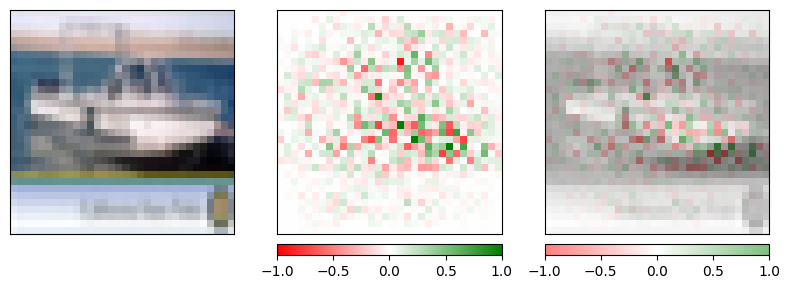

In [34]:
# initialise the interpreter
inter = Interpreter(pipe.model, method="GuidedGradCam")

# define a signle datum
datum = next(iter(dl_tr))[0][0].reshape(1, 3, 32, 32)

# define the layer of which we are interested in displaying the features
layer = pipe.model.conv2

# we will test against this class
class_ = 0

# interpret the image
output = inter.interpret(datum, class_, layer)

# visualise the interpreter
vs = Visualiser(pipe)
try:
    vs.plot_interpreter_image(inter)
except AssertionError:
    print("The heatmap is made of all zeros...")


There are many techniques that we can try out for interpretability: here is an example with **Saliency maps**: the idea is to perturb the input datum and compute the gradients of the loss with respect to the perturbation.

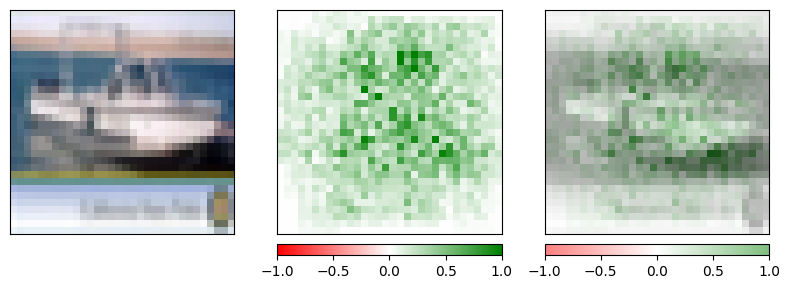

In [35]:
# we now use another model: Saliency maps
inter2 = Interpreter(pipe.model, method="Saliency")

# interpret the mage
output = inter2.interpret(datum, class_)

# visualise the results
vs = Visualiser(pipe)
try:
    vs.plot_interpreter_image(inter2)
except AssertionError:
    print("The heatmap is made of all zeros...")

## Interactive 3d visualization

You can visualise the dataset in 3D (choosing dynamically the dimensionality reduction algorithm) the dataset on tensorboard. In order to do so, just run the next cell!

In [36]:
vs.plot_3d_dataset()

# Appendix

More advanced stuff ahead!

## Extract inner data from your models

For deeper analysis of the working of deep learning models, it is possible, in giotto-deep, to easily extract tons of parameters from your models:
Here below we show you how to extract:
 - each layer parameter,
 - the decision boundary,
 - the activation functions given an input datum,
 - the gradients at each node, given an input and a target.

In [37]:

me = ModelExtractor(pipe.model, loss_fn)

list_of_layers = me.get_layers_param()

for k, item in list_of_layers.items():
    print(k, item.shape)


conv1.weight torch.Size([6, 3, 5, 5])
conv1.bias torch.Size([6])
conv2.weight torch.Size([16, 6, 5, 5])
conv2.bias torch.Size([16])
fc1.weight torch.Size([120, 400])
fc1.bias torch.Size([120])
fc2.weight torch.Size([84, 120])
fc2.bias torch.Size([84])
fc3.weight torch.Size([10, 84])
fc3.bias torch.Size([10])


In [38]:
# the decision boundary will be available on tensorboard, in the projectors section.
x = next(iter(dl_tr))[0][0]
if x.dtype is not torch.int64:  # cannot backpropagate on integers!
    res = me.get_decision_boundary(x, n_epochs=1)
    res.shape


Executing the decision boundary computations:


In [40]:
x = next(iter(dl_tr))[0]
list_activations = me.get_activations(x)
len(list_activations)


8

In [41]:
batch = next(iter(dl_tr))  # a whole batch!
if batch[0].dtype is torch.float:  # cannot backpropagate on integers!
    for gradient in me.get_gradients(batch)[1]:
        print(gradient.shape)


torch.Size([6, 3, 5, 5])
torch.Size([6])
torch.Size([16, 6, 5, 5])
torch.Size([16])
torch.Size([120, 400])
torch.Size([120])
torch.Size([84, 120])
torch.Size([84])
torch.Size([10, 84])
torch.Size([10])


/home/tsdreds/dev/bda_act/giotto-deep/gdeep/models/extractor.py:232: UserWarning:

The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:480.)



## Visualise activations and other topological aspects of your model

Finally, we show you how it is possible to extract, layer per layer, given a certain input batch, the persistence diagrams computed on the activation space. This means that, for a fixed layer, the input batch is representated as a point cloud in the space of activations for that selected layer. Out of this point cloud we compute the persistence diagrams. In giotto-deep this is literally one line of code.

In [42]:
# the diagrams can be seen on tensorboard!
vs.plot_persistence_diagrams(batch)
